In [1]:
%cd ../../

/mnt/sda/otani/Experiments/eval-detection


In [2]:
import csv
import os
import numpy as np

from mim.utils import DEFAULT_CACHE_DIR
import os
import mmcv
from mmcv.utils.config import Config
import numpy as np
import pandas as pd
from src.extensions.metrics.ot_cost import get_ot_cost, get_cmap
from src.utils import krippendorff
from src.utils import map_single
from mmdet.core.visualization.image import imshow_gt_det_bboxes, imshow_det_bboxes

from src.extensions.dataset.coco_custom import CocoOtcDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from shutil import copyfile
from mmdet.datasets import build_dataset, get_loading_pipeline

from src.utils import  visualization

%matplotlib inline

In [3]:
ab2idx = {"A":0, "B": 1}
data = []
for k in ["user_1", "user_2", "user_3"]:
    base_dir = f"data/raw/user_study/{k}/"
    user_judge = []
    for j in np.arange(1, 1100, 100):
        fn = f"{j}-{j+99}.csv"
        user_judge += [ab2idx.get(row[-1], np.nan) for row in csv.reader(open(f"{base_dir}/{fn}"))]
    data.append(user_judge)

In [4]:
# check missing data
for j, v in enumerate(data):
    for i, c in enumerate(v):
        if c is np.nan:
            print(j, i)

2 767


In [5]:
reliability_data = data
alpha = krippendorff.alpha(reliability_data=data, level_of_measurement="nominal")
print(f"all: {alpha:.3}")

skip_user = 0
alpha_max = 0
for skip in range(len(data)):
    one_out_data = [v for i, v in enumerate(data) if i!=skip]
    alpha = krippendorff.alpha(reliability_data=one_out_data, level_of_measurement="nominal")
    print(f"skip-{skip}: {alpha:.3}")
    if alpha > alpha_max:
        alpha_max = alpha
        skip_user = skip
print("skip user", skip_user)
data =  [v for i, v in enumerate(data) if i!=skip_user]
alpha = krippendorff.alpha(reliability_data=data, level_of_measurement="nominal")
print("validation", alpha)

all: 0.357
skip-0: 0.462
skip-1: 0.273
skip-2: 0.337
skip user 0
validation 0.4615240907800807


In [6]:
input_data = [row[:2] for row in csv.reader(open("data/raw/user_study/inputs.csv"))]
with open("data/raw/user_study/image_names.txt") as f:
    img_names = [line.split(".")[0] for line in f]

selected_dets = []
for v in data:
    selected_det = []
    for x, choices in zip(v, input_data):
        if not np.isnan(x):
            selected_det.append(choices[x])
        else:
            selected_det.append(np.nan)
    selected_dets.append(selected_det)
selected_dets = np.asarray(selected_dets)

N = len(selected_dets[0])
is_agree = [i for i in range(N) if selected_dets[0][i] == selected_dets[1][i]]
selected_dets = selected_dets[0, is_agree]
img_names = [img_names[i] for i in is_agree]
print(f"yolof {(selected_dets=='yolof').sum()} vs retinanet {(selected_dets=='retinanet').sum()}")

anno_data = pd.DataFrame({"img": img_names, "selected_det": selected_dets})
anno_data.head()


yolof 623 vs retinanet 149


,img,selected_det
0,000000000632,yolof
1,000000000785,yolof
2,000000001268,yolof
3,000000001490,yolof
4,000000001584,yolof


In [7]:
retina_res = mmcv.load("outputs/otc_search_param_candidates/20211027_003051/RetinaNet.pkl")
yolof_res = mmcv.load("outputs/otc_search_param_candidates/20211027_003051/YOLOF.pkl")
model_cfg = "retinanet_r50_fpn_2x_coco"

cfg = Config.fromfile(os.path.join(DEFAULT_CACHE_DIR, model_cfg + ".py"))
cfg.data.test.type="CocoOtcDataset"
cfg.data.test.test_mode = True
cfg.data.test.pop('samples_per_gpu', 0)
cfg.data.test.pipeline = get_loading_pipeline(cfg.data.train.pipeline)
dataset = build_dataset(cfg.data.test)

selected_indexes = [dataset.img_ids.index(int(x)) for x in anno_data["img"].values]
retina_res = [retina_res[i] for i in selected_indexes]
yolof_res = [yolof_res[i] for i in selected_indexes]
gts = dataset.get_gts()
gts = [gts[i] for i in selected_indexes]

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [42]:
best_acc = 0
best_param = {}
hptune_trials = {"alpha": [], "beta": [], "acc": []}

step = 0.1
for p in np.arange(0.1, 0.99, step):
    for q in np.arange(0.1, 0.99, step):
        cmap_func = lambda x, y: get_cmap(
                    x, y, alpha=p, beta=q, mode="giou", use_dummy=True
                )
        retina_cc = [get_ot_cost(x, y, cmap_func) for x, y in zip(gts, retina_res)]
        yolof_cc = [get_ot_cost(x, y, cmap_func) for x, y in zip(gts, yolof_res)]
        cc_judge = [["retinanet", "yolof"][x > y] for x, y in zip(retina_cc, yolof_cc)]
        acc = np.mean(np.asarray(cc_judge) == anno_data["selected_det"].values)
        
        print(f"alpha={p:.2}, beta={q:.2}: acc={acc:.3}")
        hptune_trials["alpha"].append(p)
        hptune_trials["beta"].append(q)
        hptune_trials["acc"].append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_param = {"alpha": p, "beta": q}
best_acc, best_param

/home/otani_mayu/miniconda3/envs/obj-detect-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


alpha=0.1, beta=0.1: acc=0.242
alpha=0.1, beta=0.2: acc=0.218
alpha=0.1, beta=0.3: acc=0.311
alpha=0.1, beta=0.4: acc=0.633
alpha=0.1, beta=0.5: acc=0.744
alpha=0.1, beta=0.6: acc=0.773
alpha=0.1, beta=0.7: acc=0.794
alpha=0.1, beta=0.8: acc=0.79
alpha=0.1, beta=0.9: acc=0.78
alpha=0.2, beta=0.1: acc=0.237
alpha=0.2, beta=0.2: acc=0.224
alpha=0.2, beta=0.3: acc=0.387
alpha=0.2, beta=0.4: acc=0.665
alpha=0.2, beta=0.5: acc=0.78
alpha=0.2, beta=0.6: acc=0.795
alpha=0.2, beta=0.7: acc=0.798
alpha=0.2, beta=0.8: acc=0.786
alpha=0.2, beta=0.9: acc=0.782
alpha=0.3, beta=0.1: acc=0.227
alpha=0.3, beta=0.2: acc=0.237
alpha=0.3, beta=0.3: acc=0.439
alpha=0.3, beta=0.4: acc=0.711
alpha=0.3, beta=0.5: acc=0.79
alpha=0.3, beta=0.6: acc=0.801
alpha=0.3, beta=0.7: acc=0.795
alpha=0.3, beta=0.8: acc=0.786
alpha=0.3, beta=0.9: acc=0.78
alpha=0.4, beta=0.1: acc=0.234
alpha=0.4, beta=0.2: acc=0.249
alpha=0.4, beta=0.3: acc=0.538
alpha=0.4, beta=0.4: acc=0.727
alpha=0.4, beta=0.5: acc=0.803
alpha=0.4, be

(0.805699481865285, {'alpha': 0.5, 'beta': 0.6})

<AxesSubplot:xlabel='alpha', ylabel='beta'>

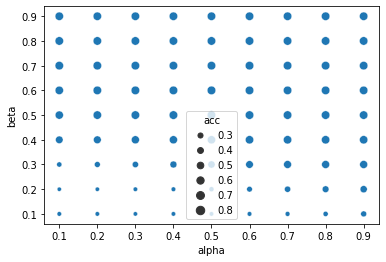

In [43]:
sns.scatterplot(x="alpha", y="beta", size="acc", data=hptune_trials)

In [8]:
cmap_func = lambda x, y: get_cmap(
                    x, y, alpha=0.5, beta=0.6, mode="giou", use_dummy=True
                )
retina_cc = [get_ot_cost(x, y, cmap_func) for x, y in zip(gts, retina_res)]
yolof_cc = [get_ot_cost(x, y, cmap_func) for x, y in zip(gts, yolof_res)]
cc_judge = [["retinanet", "yolof"][x > y] for x, y in zip(retina_cc, yolof_cc)]

/home/otani_mayu/miniconda3/envs/obj-detect-analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


In [9]:
df = pd.read_csv("outputs/human_consistency/map_vs_human.csv")
df["oc_judgment"] = cc_judge
df["img"] = anno_data.img
df.head()

,Unnamed: 0,human_judgment,map_judgment,oc_judgment,img
0,0,yolof,yolof,yolof,000000000632
1,1,yolof,yolof,yolof,000000000785
2,2,yolof,yolof,yolof,000000001268
3,3,yolof,yolof,yolof,000000001490
4,4,yolof,yolof,yolof,000000001584


In [10]:
def cvrt_result(bbox_result):
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)
    bboxes = np.vstack(bbox_result)
    return bboxes, labels

cb_p = sns.color_palette("colorblind")
det_c = (np.asarray(cb_p[2])*255).astype(np.uint8)[::-1]
gt_c = (np.asarray(cb_p[3])*255).astype(np.uint8)[::-1]

img_ids = ["000000023272", "000000089078", "000000235857", "000000350019"]

for i in df[(df.human_judgment==df.oc_judgment)&(df.human_judgment!=df.map_judgment)].index:
    img_id = df.img[i]
    if img_id not in img_ids:
        continue
    org_idx = selected_indexes[i]
    data_info = dataset.prepare_train_img(org_idx)
    ann_info = data_info["ann_info"]
    retina_map, retina_map_report =  map_single.bbox_map_eval(retina_res[i], ann_info)
    yolof_map, yolof_map_report =  map_single.bbox_map_eval(yolof_res[i], ann_info)
    print(data_info["filename"])
    print(f"mAP_single: retina-{retina_map}, yolof-{yolof_map}")
    print(f"OC-cost: retina-{retina_cc[i]:.2}, yolof-{yolof_cc[i]:.2}")

    ims = []
    for dets, model_name in zip((retina_res[i], yolof_res[i]), ["retinanet", "yolof"]):
        dets, labels = cvrt_result(dets)
        if model_name=="retinanet":
            occ = retina_cc[i]
            map_v = retina_map
        else:
            occ = yolof_cc[i]
            map_v = yolof_map
        out_file = f"outputs/figs/user_study/examples/{img_id}_{model_name}_oc-cost({occ:.3})_map({map_v:.3}).pdf"
        im = visualization.imshow_det_bboxes(
            data_info["filename"],
            dets,
            labels,
            class_names=dataset.CLASSES,
            bbox_color=det_c,
            text_color=det_c,
            thickness=3,
            font_size=22,
            show=False,
            out_file=out_file)

data/coco/val2017/000000023272.jpg
mAP_single: retina-0.6, yolof-0.55
OC-cost: retina-0.28, yolof-0.19
data/coco/val2017/000000089078.jpg
mAP_single: retina-0.4, yolof-0.35
OC-cost: retina-0.32, yolof-0.24
data/coco/val2017/000000235857.jpg
mAP_single: retina-0.8666666746139526, yolof-0.8333333432674408
OC-cost: retina-0.19, yolof-0.075
data/coco/val2017/000000350019.jpg
mAP_single: retina-1.0, yolof-0.95
OC-cost: retina-0.24, yolof-0.098


In [ ]:

for i, x in enumerate(retina_map_report):
    for j, c in enumerate(dataset.CLASSES):
        if c in ["car", "cat", "truck"]:
            print(c)    
            print(x[j])